# Jigsaw Multilingual Toxic Comment Classification
#### Members: 1055090216 歐語四 楊淳安、105703029 資科四 邱斯、105703036 資科四 黃亦晨、105703053 資科四 陳則明

# 1. 動機
    因為現在網際網路蓬勃發展的緣故，大家都有資格在網路上留言，但因為匿名的緣故，留言區常常會充滿著謾罵聲，要是我們的 Deep Learning Model 能判斷出哪些是人身攻擊的言論，就可以禁聲那些人，也可以不用去荼毒各個看板的管理員，此外這個問題還有一個重點，就是需要讓機器從單一語言的資料去推斷出其他語言的留言是否是惡意評論，其實這樣才更接近真正的人工智慧，藉由已有的知識去推斷未知，就像不可能所有的動物都被加入分類器，當有新的動物時，可以由其他動物的特徵來做一個推斷。
# 2. 資料集
    我們採用 Kaggle 中的 Jigsaw Multilingual Toxic Comment Classification 資料集，在此資料集中，資料分為 train, validation 和 test 三個部分，由於資料有部分是整理過的，所以我們只需將資料集中我們所需的部分取出即可，下列為我們使用到的資料：
    1. ID - 每一筆資料的 ID
    2. comment_text - 一段文字，模型必須去判斷其是否為toxic，輸入時長度不固定，但整理時統一取 comment_text 長度為 128。
    3. input_word_ids, input_mask, all_segment_id - BERT 所需的欄位
    4. toxic - 0 或是 1，如果是 1 時，代表段文字為惡意，反之為 0 時，該段文字非惡意。
# 3. 模型選擇
    在提案時，我們提出多個 Word Embeddings 和 Model，在實作時，我們從中選出了三個我們較有興趣的模型，分別為: GloVe + LSTM, GloVe + GRU ,以及 Multilingual valid  BERT，而我們也在訓練結果中發現 BERT 的訓練時間明顯短於 GloVe + LSTM 和 GloVe + GRU，但其呈現出的訓練結果卻不輸 GloVe + LSTM 和 GloVe + GRU
    1. GloVe + LSTM(300) English valid auc score: 0.97
    2. GloVe + GRU(300) English valid score: 0.98
    3. Last layer of BERT + average pooling + max pooling
       English valid auc score: 0.979
       Multilingual valid auc score: 0.86
       test score: 0.8392
# 4. 程式碼
    因為程式的執行皆在 Kaggle 上，資料集也皆為從 Kaggle 上直接引入，又因模型分了兩種語法(pythorch 和 tensorflow(keras))，兩者在啟動TPU上有些不同，而導致相容性上有點問題，因此分了兩個檔案，以下為 Kaggle 的程式碼網址：
    
    1. GloVe + LSTM(300) & GloVe + GRU(300) : https://www.kaggle.com/ych1997ych/final-project
    2. BERT : https://www.kaggle.com/stanleychu/jigsaw-toxic-comment
# 5. 分工
    - 楊淳安 : LSTM 程式碼
    - 邱斯 : BERT 程式碼、報告撰寫
    - 黃亦晨 : GRU 程式碼、報告撰寫
    - 陳則明 : XLM 程式碼(因結果不如預期，所以決定不放)、報告撰寫、題目發想

In [1]:
%matplotlib inline

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import GRU,SimpleRNN,LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

import sys
import os
import numpy as np
import pandas as pd
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

Using TensorFlow backend.


# 資料觀察
1. 查看取出的資料是否有缺值
2. 觀察 train 和 valid 中 toxic 和 non-toxic 的比例是否相近，確定他們的分佈是類似的
3. 雖然兩者的分佈是相近的，但其實 toxic 和 non-toxic 的比例是有很大的差距的，曾嘗試將兩者的比例都拉到將近 50% 但模型的成果並沒有太大的改善，因此決定保留原來的分佈
4. train 當中全是英文的評論，valid 當中放置三個非英文的資料，三個語言的資料量並沒有太大的差距

In [2]:
valid = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv")
train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv")
test = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv")
submit = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv")
train = train[['id', 'comment_text', 'input_word_ids', 'input_mask','all_segment_id', 'toxic']].iloc[:20000]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              20000 non-null  object
 1   comment_text    20000 non-null  object
 2   input_word_ids  20000 non-null  object
 3   input_mask      20000 non-null  object
 4   all_segment_id  20000 non-null  object
 5   toxic           20000 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


查看 toxic 文字在整個 train 以及 valid 中的比例

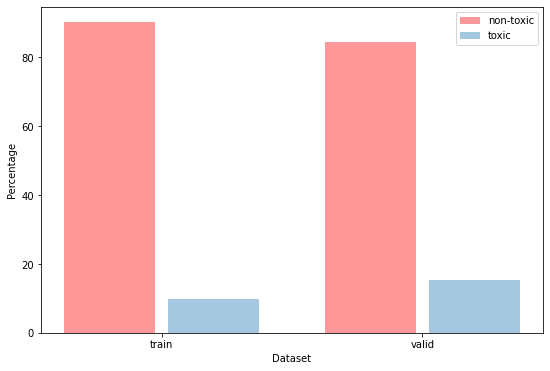

In [4]:
train_distribution = train["toxic"].value_counts().values
valid_distribution = valid["toxic"].value_counts().values

non_toxic = [train_distribution[0] / sum(train_distribution) * 100, valid_distribution[0] / sum(valid_distribution) * 100]
toxic = [train_distribution[1] / sum(train_distribution) * 100, valid_distribution[1] / sum(valid_distribution) * 100]

plt.figure(figsize=(9,6))
plt.bar([0, 1], non_toxic, alpha=.4, color="r", width=0.35, label="non-toxic")
plt.bar([0.4, 1.4], toxic, alpha=.4, width=0.35, label="toxic")
plt.xlabel("Dataset")
plt.ylabel("Percentage")
plt.xticks([0.2, 1.2], ["train", "valid"])
plt.legend(loc="upper right")

plt.show()

In [5]:
print(f"train: \nnon-toxic rate: {train_distribution[0] / sum(train_distribution) * 100: .2f} %\ntoxic rate: {train_distribution[1] / sum(train_distribution) * 100: .2f} %")
print(f"valid: \nnon-toxic rate: {valid_distribution[0] / sum(valid_distribution) * 100: .2f} %\ntoxic rate: {valid_distribution[1] / sum(valid_distribution) * 100: .2f} %")

train: 
non-toxic rate:  90.27 %
toxic rate:  9.74 %
valid: 
non-toxic rate:  84.62 %
toxic rate:  15.38 %


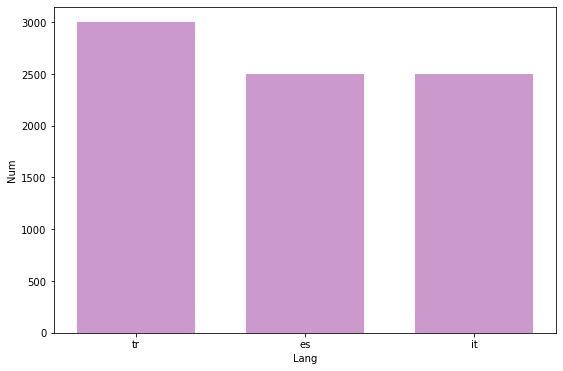

In [6]:
lang = valid["lang"].value_counts()

plt.figure(figsize=(9, 6))
plt.xlabel("Lang")
plt.ylabel("Num")
plt.xticks([0.2, 0.6, 1], ["tr", "es", "it"])
plt.bar([0.2, 0.6, 1], lang, color="purple", width=0.28, alpha=.4)
plt.show()

# TPU

In [7]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# 讀入資料
1. 從競賽中取出未經預處理的訓練資料 `jigsaw-toxic-comment-train.csv`
2. 取出驗證資料 `validation.csv` 和測試資料 `test.csv`
3. 丟棄不需要的欄位，保留 `[id, comment_text, toxic]`，comment_text 代表 twitter 的留言，toxic 是 1 表示惡意，0 表示安全

In [8]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

train.drop(['severe_toxic','obscene','threat','insult','identity_hate'], axis=1, inplace=True)

從原始 223549 筆訓練資料中讀取出 25000 筆做為我們的訓練和驗證資料

從中我們找到最大長度的句子是 - 1403

In [9]:
train = train.loc[:25000-1,:]
print(f"訓練資料總數：{train.shape[0]}\n句子最大長度：{train['comment_text'].apply(lambda x:len(str(x).split())).max()}")

訓練資料總數：25000
句子最大長度：1403


定義本次競賽中作為評估的函式 **roc_auc**，以下為所需的兩個輸入：
- model 預測出來的 predictions
- 資料中的標準答案

In [10]:
def roc_auc(predictions,target):
  
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    
    return roc_auc

將 25000 筆資料分割為 `train` 跟 `valid` (0.2)

$ 25000\times0.2=5000 $ (Validation data)

$ 25000-5000=20000 $ (Training data)


In [11]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# Tokenizer
1. 將每一筆資料的評論部分做斷詞，得到 token sequences 
2. 將每筆資料調整成同一大小 (128字) --> zero padding
3. 最後 3 個資料集 (train, valid, test) 的長度分別是 (20000, 5000, 63812)，每個句子因為 padding，所以都是 128
4. word_index 紀錄著每一個字對應的 id

In [12]:
token = text.Tokenizer(num_words=None)
max_len = 128

token.fit_on_texts(list(xtrain)+ list(xvalid)) #+ list(xvalid)+list(test)
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index
print(xtrain_pad.shape, xvalid_pad.shape)


(20000, 128) (5000, 128)


# Word Embedding
1. 載入 GloVe 的詞向量，將之整理成一個 dict `embeddings_index`
2. 每一行的第一個字是一個單字，剩下是他對應的向量
3. 我們最後可以看到整個 GloVe 有 2196017 個單字存在

In [13]:
embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 2196017 word vectors.


In [14]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# LSTM
1. 將第一層設定為 300 維的 Embedding layer
2. 三層 LSTM 層，各 300 個神經元
3. 設定 drop out，避免 overfitting
3. 將輸出使用 sigmoid 拉到 0~1 之間
4. Compiling，因為是二分類別所以使用 binary_crossentropy 當 loss function，Adam 當我們 optimization

In [15]:
%%time
with strategy.scope():
    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3,return_sequences=True))
    model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3,return_sequences=True))
    model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 300)          17624700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 300)          721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 300)          721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 19,788,601
Trainable params: 2,163,901
Non-trainable params: 17,624,700
_________________________________________________________________
CPU times: user 2.53 s, sys: 1.24 s, total: 3.77 s
Wall time: 4.54 s


# Train

In [16]:
%%time

model.fit(xtrain_pad, ytrain, epochs=5, batch_size=48*strategy.num_replicas_in_sync)

Epoch 1/5
20000/20000 [==============================] - 110s 5ms/step - loss: 0.2448 - accuracy: 0.9122
Epoch 2/5
20000/20000 [==============================] - 106s 5ms/step - loss: 0.1562 - accuracy: 0.9427
Epoch 3/5
20000/20000 [==============================] - 105s 5ms/step - loss: 0.1334 - accuracy: 0.9499
Epoch 4/5
20000/20000 [==============================] - 106s 5ms/step - loss: 0.1296 - accuracy: 0.9517
Epoch 5/5
20000/20000 [==============================] - 105s 5ms/step - loss: 0.1192 - accuracy: 0.9557
CPU times: user 4.53 s, sys: 716 ms, total: 5.25 s
Wall time: 8min 54s


# LSTM模型在 valid 的表現 

In [17]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.97%


# GRU
1. 將第一層設定為 300 維的 Embedding layer
2. 三層 GRU 層，各 300 個神經元
3. 設定 drop out，避免 overfitting
4. 將輸出使用 sigmoid 拉到 0~1 之間
5. Compiling，因為是二分類別所以使用 binary_crossentropy 當 loss function，Adam 當我們 optimization

In [19]:
%%time
with strategy.scope():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(GRU(300,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(GRU(300,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(GRU(300,return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 300)          17624700  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 128, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 300)          540900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128, 300)          540900    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 300)              

# Train

In [19]:
#GRU模型訓練
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
20000/20000 [==============================] - 115s 6ms/step - loss: 0.2305 - accuracy: 0.9236
Epoch 2/5
20000/20000 [==============================] - 112s 6ms/step - loss: 0.1398 - accuracy: 0.9506
Epoch 3/5
20000/20000 [==============================] - 113s 6ms/step - loss: 0.1255 - accuracy: 0.9528
Epoch 4/5
20000/20000 [==============================] - 113s 6ms/step - loss: 0.1101 - accuracy: 0.9583
Epoch 5/5
20000/20000 [==============================] - 113s 6ms/step - loss: 0.1015 - accuracy: 0.9632


# GRU模型在 valid 的表現

In [20]:
#使用 valid 測試資料的 AUC 結果
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.98%


# BERT 

# TPU
1. 安裝新版的 pip，去除 warning
2. 安裝為了使用 TPU 的相依套件

In [1]:
!python -m pip install --upgrade pip
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 1.5 MB 2.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  61797      0 --:--:-- --:--:-- --:--:-- 61797
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+82fd1c8
Uninstalling torchvision-0.6.0a0+82fd1c8:
  Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/91.0 MiB.                                 

In [2]:
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import IPython
import sys

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import transformers
from transformers import BertForSequenceClassification, BertPreTrainedModel, BertConfig, BertModel
import torch.nn as nn
import torch.nn.functional as F

import torch_xla
import torch_xla.core.xla_model as xm

# BERT 基礎參數設定

In [3]:
class config:
    EPOCHS = 1
    BATCH_SIZE = 32
    VAL_BATCH_SIZE = 128
    TEST_BATCH_SIZE = 128
    LR = 3e-5

In [4]:
valid = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv")
train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv")
test = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv")
submit = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv")
evalid = train[['id', 'comment_text', 'input_word_ids', 'input_mask','all_segment_id', 'toxic']].iloc[20001:25001]
train = train[['id', 'comment_text', 'input_word_ids', 'input_mask','all_segment_id', 'toxic']].iloc[:20000]

# Dataset
1. 因為放進 BERT 的資料需要三樣東西，分別是 (token_tensor, segment_tensor, mask_tensor)
    - token tensor 就是每一個句子轉換為 id 之後的句子
    - segment tensor 是因為 BERT 的應用中某一些情況是兩個句子的輸入，必須告訴模型哪一些是第一句，哪一些是第二句
    - mask tensor 主要跟 BERT 兩個主要的任務有關，BERT 會把單字遮罩起來當作克漏字來預測 (另一個任務是 Next Sentence Prediction)
2. 將那三樣東西從 `jigsaw-toxic-comment-train-processed-seqlen128.csv` (BERT 的預處理)拿出來，還有正確答案 label_tensor

In [5]:
class TweetDataset(Dataset):
    def __init__(self, mode, df):
        self.mode = mode
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        token, segment, mask = self.df.loc[idx, ["input_word_ids", "all_segment_id", "input_mask"]].values
        if self.mode=="train" or self.mode == "valid":
            label_tensor = torch.tensor(self.df.loc[idx, "toxic"])
        else:
            label_tensor = torch.tensor(-1)
        tokens_tensor = torch.tensor([int(i) for i in token[1:-1].split(",")])
        segments_tensor = torch.tensor([int(i) for i in segment[1:-1].split(",")])
        masks_tensor = torch.tensor([int(i) for i in mask[1:-1].split(",")])
           
        return tokens_tensor, segments_tensor, masks_tensor, label_tensor

# Dataloader
1. 將從 csv 讀出來的資料經過剛剛的 Dataset 進行處理
2. 將不同的語言從 valid 分離出來，分別存放，為了觀察各語言的情況
3. 之後切割出對應的 batch size 

In [6]:
lang = {'Spanish': 'es', 'Italian': 'it', 'Turkish': 'tr'}

validsets = {}
for i, k in lang.items():
    validsets[i] = TweetDataset("valid", valid[valid["lang"] == k].reset_index(drop=True))
trainset = TweetDataset("train", train)
validset = TweetDataset("valid", valid)
testset = TweetDataset("test", test)
evalidset = TweetDataset("valid", evalid)

validloaders = {}
for i, k in validsets.items():
    validloaders[i] = DataLoader(k, batch_size=config.VAL_BATCH_SIZE, num_workers=4, shuffle=False)
trainloader = DataLoader(trainset, batch_size=config.BATCH_SIZE, num_workers=4, shuffle=False)
validloader = DataLoader(validset, batch_size=config.VAL_BATCH_SIZE, num_workers=4, shuffle=False)
testloader = DataLoader(testset, batch_size=config.TEST_BATCH_SIZE, num_workers=4, shuffle=False)
evalidloader = DataLoader(evalidset, batch_size=config.VAL_BATCH_SIZE, num_workers=4, shuffle=False)

# BERT 架構
1. 讀取 bert-base-multilingual-cased 的預訓練模型
2. 取出最後一層的 hidden states 而不是 CLS (句首的特殊字元) 的資訊 --> 經過嘗試使用 CLS 的成績比較低落
3. 將取出來的 hidden states 做一次 average pooling，接著做 max pooling，將兩個的結果串接起來，因此維度變為原來的兩倍 ($2\times768$)
4. 接著 dropout(0.3) --> linear(tanh) --> output


In [7]:
class Model(nn.Module):
    
    def __init__(self, labels=1):
        
        super().__init__()
        
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.num_features = self.bert.pooler.dense.out_features
        self.labels = labels
        
        self.drop = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.num_features * 2, self.num_features)
        self.logit = nn.Linear(self.num_features, self.labels)
        
    def forward(self, tokens_tensors, segments_tensors, masks_tensors):
        
        hidden_states, cls = self.bert(input_ids=tokens_tensors, token_type_ids=segments_tensors, attention_mask=masks_tensors)
        avgpool = torch.mean(hidden_states, 1)
        maxpool, _ = torch.max(hidden_states, 1)
        cat = torch.cat((avgpool, maxpool), 1)
        x = self.drop(cat)
        x = torch.tanh(self.fc1(x))
        output = self.logit(x)

        return output

In [8]:
model = Model()

確認模型的輸出跟所設計的架構是否相同

In [9]:
model

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

# Device
- 將整個模型放入 TPU 當中

In [10]:
device = xm.xla_device()
model.to(device)
print(f"Now we use {device}\n")

Now we use xla:1



# Train - function
1. optimizer: Adam, scheduler: lr 隨著步驟下降, loss function: BCEWithLogitsLoss
2. 將每一個 input 分別放進 tensor 以利計算
3. loss --> backward --> optimize --> schedule
4. 計算一個 epoch 結束後 valid 的成績

In [11]:
def training(model, warmup_prop=0.1):

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR)
    num_warmup_steps = int(warmup_prop * config.EPOCHS * len(trainloader))
    num_training_steps = config.EPOCHS * len(trainloader)
    scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
    loss_fun = torch.nn.BCEWithLogitsLoss(reduction='mean').to(device)    

    for epoch in range(config.EPOCHS):
        model.train()
        
        optimizer.zero_grad()
        avg_loss = 0
        
        for data in tqdm(trainloader):             
            tokens_tensor, segments_tensor, masks_tensor, labels_tensor = [k.to(device) for k in data if k is not None]
            output = model(tokens_tensor, segments_tensor, masks_tensor)
            loss = loss_fun(output.view(-1).float(), labels_tensor.float().to(device))
            loss.backward()
            avg_loss += loss.item() / len(trainloader)

            xm.optimizer_step(optimizer, barrier=True)
            scheduler.step()
            model.zero_grad()
            optimizer.zero_grad()
                
        model.eval()
        preds = []
        truths = []
        avg_val_loss = 0.

        with torch.no_grad():
            for data in validloader:
                tokens_tensor, segments_tensor, masks_tensor, labels_tensor = [k.to(device) for k in data if k is not None]
                output = model(tokens_tensor, segments_tensor, masks_tensor)
                loss = loss_fun(output.detach().view(-1).float(), labels_tensor.float().to(device))
                avg_val_loss += loss.item() / len(validloader)
                
                probs = torch.sigmoid(output).detach().cpu().numpy()
                preds += list(probs.flatten())
                truths += list(labels_tensor.detach().cpu().numpy().flatten())
            score = roc_auc_score(truths, preds)
        
        lr = scheduler.get_last_lr()[0]
        print(f'[Epoch {epoch + 1}] lr={lr:.1e} loss={avg_loss:.4f} val_loss={avg_val_loss:.4f} val_auc={score:.4f}')

# Predict
1. 將超過 0.5 定為有惡意的評論
2. 輸入模型、切割好 batch 的 dataloader、跟原來的 dataframe 就算算出預測的答案

In [12]:
threshold = lambda x: 1 if x>=0.5 else 0

def predict(model, dataloader, df, isAccuracy=True):
 
    model.eval().to(device)
    preds = np.empty((0, 1))
    accuracy = None

    with torch.no_grad():
        for data in tqdm(dataloader):
            tokens_tensor, segments_tensor, masks_tensor, labels_tensor = [k.to(device) for k in data if k is not None]
            probs = torch.sigmoid(model(tokens_tensor, segments_tensor, masks_tensor)).detach().cpu().numpy()
            preds = np.concatenate([preds, probs])
            
    preds = preds.reshape(len(preds))        
    predicts = np.array([threshold(i) for i in preds])
    if isAccuracy:
        accuracy = (df["toxic"].values == predicts).sum() / len(df)

    return preds, predicts, accuracy 

# BERT 在訓練之前的成績
- 分別是查看 train、各個語言的 valid 在訓練之前的成果
- 從這裡我們可以看出，不管是 train 還是 valid 的各種語言在沒有訓練之前的 auc 跟 accuracy 的表現都是非常不好的

In [13]:
# before training model accuracy
pre, pre_class, accuracy = predict(model, trainloader, train)
auc = roc_auc_score(train["toxic"].values, pre_class)
print("Train: ")
print(f"Model before fine-tune accuracy: {accuracy * 100:.3f}%\nModel before fine-tune AUC: {auc:.3f}")

for key, value in validloaders.items():
    pre, pre_class, accuracy = predict(model, value, valid[valid["lang"] == lang[key]].reset_index(drop=True))
    auc = roc_auc_score(valid[valid["lang"] == lang[key]].reset_index(drop=True)["toxic"].values, pre_class)
    print(f"{key} Valid: ")
    print(f"Model before fine-tune accuracy: {accuracy * 100:.2f}%\nModel before fine-tune AUC: {auc:.3f}")

pre, pre_class, accuracy = predict(model, validloader, valid)
auc = roc_auc_score(valid["toxic"].values, pre_class)
print(f"Combined Valid: ")
print(f"Model before fine-tune accuracy: {accuracy * 100:.2f}%\nModel before fine-tune AUC: {auc:.3f}")


Train: 
Model before fine-tune accuracy: 77.025%
Model before fine-tune AUC: 0.472



Spanish Valid: 
Model before fine-tune accuracy: 51.56%
Model before fine-tune AUC: 0.492



Italian Valid: 
Model before fine-tune accuracy: 57.00%
Model before fine-tune AUC: 0.474



Turkish Valid: 
Model before fine-tune accuracy: 60.50%
Model before fine-tune AUC: 0.457



Combined Valid: 
Model before fine-tune accuracy: 56.61%
Model before fine-tune AUC: 0.479


# Train
1. 訓練階段只訓練了一個 epoch，因為之前嘗試使用更多 epoch 時，loss 不斷的上升
2. 在 5 分鐘以內能完成了 20000 筆資料的訓練 (曾嘗試使用較大量的資料但 performance 沒有太大的進步)

In [14]:
%%time 

training(model)


[Epoch 1] lr=0.0e+00 loss=0.1509 val_loss=0.3506 val_auc=0.8612
CPU times: user 1min 7s, sys: 3.84 s, total: 1min 11s
Wall time: 4min 15s


# BERT 在訓練之後的成績
1. 經過參數的微調讓 BERT 更符合現在這個任務
2. 結果可以看出進步非常地顯著，AUC 跟 accuracy 在所有的資料集上幾乎都有達到 0.8 以上
3. 透過 fine-tune 能讓 transfer learning 產生最大的效果


In [22]:
# After training model accuracy
pre, pre_class, accuracy = predict(model, trainloader, train)
auc = roc_auc_score(train["toxic"].values, pre)
print("Train: ")
print(f"Model after fine-tune accuracy: {accuracy * 100:.3f}%\nModel after fine-tune AUC: {auc:.3f}")
  
for key, value in validloaders.items():
    pre, pre_class, accuracy = predict(model, value, valid[valid["lang"] == lang[key]].reset_index(drop=True))
    auc = roc_auc_score(valid[valid["lang"] == lang[key]].reset_index(drop=True)["toxic"].values, pre)
    print(f"{key} Valid: ")
    print(f"Model after fine-tune accuracy: {accuracy * 100:.2f}%\nModel after fine-tune AUC: {auc:.3f}")

pre, pre_class, accuracy = predict(model, validloader, valid)
auc = roc_auc_score(valid["toxic"].values, pre)
print(f"Combined Valid: ")
print(f"Model after fine-tune accuracy: {accuracy * 100:.2f}%\nModel after fine-tune AUC: {auc:.3f}")


Train: 
Model after fine-tune accuracy: 96.950%
Model after fine-tune AUC: 0.986



Spanish Valid: 
Model after fine-tune accuracy: 85.44%
Model after fine-tune AUC: 0.852



Italian Valid: 
Model after fine-tune accuracy: 82.24%
Model after fine-tune AUC: 0.811



Turkish Valid: 
Model after fine-tune accuracy: 89.90%
Model after fine-tune AUC: 0.929



Combined Valid: 
Model after fine-tune accuracy: 86.11%
Model after fine-tune AUC: 0.860


In [23]:
pre, pre_class, accuracy = predict(model, evalidloader, evalid)
auc = roc_auc_score(evalid["toxic"].values, pre)
print("Evalid: ")
print(f"Model after fine-tune accuracy: {accuracy * 100:.3f}%\nModel after fine-tune AUC: {auc:.3f}")


Evalid: 
Model after fine-tune accuracy: 95.740%
Model after fine-tune AUC: 0.979


In [16]:
torch.save(model.state_dict(), "./model.bin")

# 預測測試資料並輸出

In [17]:
pre, pre_class, accuracy = predict(model, testloader, test, False)
submit['toxic'] = pre
submit.to_csv('submission.csv', index=False)
submit.head()

,id,toxic
0,0,0.059432
1,1,0.002593
2,2,0.157536
3,3,0.041402
4,4,0.003161


# 視覺化 Attention
- 從這個視覺話工具中我們可以看出，在 BERT 的某些層是能知道『他 - 阿明』之間的關係，或是『給 - 阿明』這個動作的關係
- 不同的 head 能監控不依樣的特徵

In [18]:
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
    sys.path += ['bertviz_repo']

from transformers import BertTokenizer, BertModel
from bertviz import head_view

def call_html():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))


Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1074, done.
remote: Total 1074 (delta 0), reused 0 (delta 0), pack-reused 1074
Receiving objects: 100% (1074/1074), 99.41 MiB | 26.30 MiB/s, done.
Resolving deltas: 100% (687/687), done.


In [19]:
model_version = 'bert-base-chinese'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

sentence_a = "阿明去買東西，"
sentence_b = "回來的時候要給他錢。"

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6. 結論
    平常看到各大論壇對 BERT 的鼓吹，述說著他各種的好，但始終沒有自己體驗過，所以想透過這次的報告，來稍微了解一下他的能力，見識到 `Attention Is All You Need`。我們使用大家最常見的兩種 RNN (LSTM 和 GRU) 來和 BERT 在相同的英文資料上訓練，首先在訓練資料上我們都挑選了 20000 筆資料，接著就是設計模型的架構，RNN 方面我們需要去重新構思整個模型的架構，然而 BERT 只需要取出隱藏層的特徵，就可以套用在許多不同的任務上，不用每一次都重新煩惱設計，而在訓練的時間上 BERT 也大大的勝出，BERT 花大概 5 分鐘就能完成，另外兩個模型卻因為需要依照著時間序列將文字放入而較難平行化，所以需要花較長的時間，大概 10 分鐘才能完成，最後在準確率上面，雖然 BERT 在 fine-tune 之前的成績是很糟糕的，但經過了一些任務資料的修正就不輸 LSTM 和 GRU 了，可能也是因為 LSTM 和 GRU 都只有從單方面去獲得文字資訊，不像 BERT 一樣同時獲得雙向的資訊，LSTM 和 GRU 還是可能可以大大超越 BERT 但那勢必需要付出很大的代價，更多的訓練資料，更長的訓練時間，更複雜的模型架構。在這次的比賽中收穫最多應該是使用 GPU 和 TPU 的加速，平常在自己的電腦很少有機會體驗到這些加速器的好處，一開始使用 CPU 大概要花費好幾天才能訓練完，一經加速之後馬上縮減到半小時之內，可以讓我們在有限的時間之內嘗試更多的組合，擁有更多的容錯空間，只是 Kaggle 提供的給每人免費的時間也只有 30 個小時，所以也沒有到能肆無忌憚的胡亂嘗試。